

# Alexa Project Code Contribution

> Author: Chet (techds on GitHub)  
> * CNN and Multinomial logistic regression: 
>   * image data ingestion (raw images - Mel-Spectrograms - via image data generator)  
>   * audio data ingestion (mfcc features saved to .npy files) 
>   * model prediction  
>   * model authentication 


In [1]:
# imports

from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback, \
                            CSVLogger, EarlyStopping, TensorBoard
from keras.layers import AveragePooling2D, BatchNormalization, Conv2D, \
                         MaxPooling2D, Dense, Dropout, Activation, Flatten,\
                         ZeroPadding2D
from keras.models import load_model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img,\
                                      ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import np_utils

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.utils import shuffle as sh

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from pydub import AudioSegment as audio
from pydub.playback import play 
import re
import time

# functions

def plot_loss_acc(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['acc'], 'o-', c='r')
    ax.plot([None] + hist.history['val_acc'], '*-', c='g')
    ax.legend(['Train acc', 'Val acc'], loc = 0)
    ax.set_title('Training/Validation Accuracy per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy') 
    plt.plot()
    
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-', c='r')
    ax.plot([None] + hist.history['val_loss'], '*-', c='g')
    ax.legend(['Train loss', 'Val loss'], loc = 0)
    ax.set_title('Training/Validation Loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss') 
    plt.plot()
    
def tag_cols(df,beg_str,last_col_name):
    colnames = []
    beg_str = str(beg_str)
    len_col = len(df.columns)
    for l in range(len_col-1 ):
        name = beg_str + str(l+1)
        colnames.append(name)
    last_col_name = str(last_col_name)
    colnames.append(last_col_name)
    df.columns = colnames
    
    
print('Ready for data ingestion and model prediction')


Using TensorFlow backend.


Ready for data ingestion and model prediction


### CNN

Found 750 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 10 images belonging to 10 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 100, 6)       168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 74, 50, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 48, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 36, 24, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               1659000   
_________________

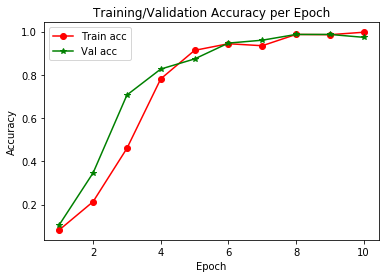

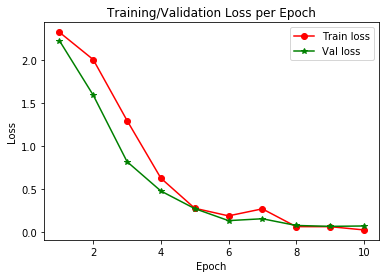

In [2]:

# define dir paths
trn_dir = './Desktop/nn_audio/trn/'
val_dir = './Desktop/nn_audio/val/'
tst_dir = './Desktop/nn_audio/tst/'

# get speakers/labels
val_imgs = []
speakers = [] 
for path,subdirs,files in os.walk(val_dir):
    for subdir in subdirs:
        speakers.append(subdir)
        folder_path = os.path.join(val_dir + subdir + '/')
        folder_path = ''.join(folder_path)
        for files in os.listdir(folder_path):
            if files.endswith('.jpg'):
                val_imgs.append(files)

speakers = sorted(speakers)

#> instantiate vars:
img_width, img_height = 150, 102
n_tr_samples = 750
n_vl_samples = 150
n_te_samples = 10  
n_epochs = 10
input_tensor = (img_width, img_height, 3)
prob_thresh = .95 
num_prob_thresh = 0 
floor = 10  
num_features = 25


#---
# Set up for cnn prediction
# Read images in dirs and generate batches of image data
datagen = ImageDataGenerator(rescale=1./255)

tr_gen = datagen.flow_from_directory(
            trn_dir,                             
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode='categorical',
            shuffle=False) 

tr_lab = tr_gen.classes
out = len(np.unique(tr_lab)) 


vl_gen = datagen.flow_from_directory(
            val_dir,                            
            target_size=(img_width, img_height),
            batch_size=16,
            class_mode='categorical',
            shuffle=False) 

vl_lab = vl_gen.classes
vl_jump = int(len(vl_lab)/out)

te_gen = datagen.flow_from_directory(
            tst_dir,                            
            target_size=(img_width, img_height),
            batch_size=2,
            class_mode='categorical',   
            shuffle=False) 

te_lab = te_gen.classes
te_jump = int(len(te_lab)/out)

# create and run cnn model
cnn = Sequential()

cnn.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_tensor))
cnn.add(AveragePooling2D())

cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
cnn.add(AveragePooling2D())

cnn.add(Flatten())
cnn.add(Dense(units=120, activation='relu'))

cnn.add(Dense(units=84, activation='relu'))

cnn.add(Dense(out))
cnn.add(Activation(tf.nn.softmax))

cnn.summary()

# Compile and run the model
cnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

hist_cnn = cnn.fit_generator(
            tr_gen,                  
            steps_per_epoch=100,
            epochs=n_epochs,         
            validation_data=vl_gen,  
            validation_steps=10)

plot_loss_acc(hist_cnn)


In [3]:
# CNN prediction

# predict test set
te_gen.reset() 
tst_features_mod = cnn.predict_generator(te_gen, n_te_samples, verbose=True)

features_mod = tst_features_mod
jump = te_jump

prob_thresh = float(prob_thresh)*100
for r in range(len(features_mod)):
    j = r//jump 
    print('For out-of-sample command {0} uttered by {1}'\
          .format(r+1, speakers[j].upper() ) )
    class_prob_ls = features_mod[r]
    max_prob = np.max(class_prob_ls)
    max_prob_val = round(max_prob * 100,2)
    max_prob_ind = class_prob_ls.tolist().index(max_prob)  
    pred_label = speakers[max_prob_ind]
    print('I\'m %s%% sure that you are %s.\n'\
              % (max_prob_val, pred_label.upper() ) )
    # to avoid error in jupyter nb (no such error in Spyder) 
    if j == 9:
        break

# predict voice command
pred_dir = './Desktop/nn_audio/chk/'
pred_imgs = []
for files in os.listdir(pred_dir + '/' + 'speaker'):
    if files.endswith('.jpg'):
        pred_imgs.append(files)
print(pred_imgs)
num_pred = len(pred_imgs)

batch_size = 1
te_gen = datagen.flow_from_directory(
                    directory=pred_dir,
                    target_size=(img_width, img_height),
                    #color_mode='rgb',
                    batch_size=batch_size,
                    class_mode=None,
                    shuffle=False)
te_gen.reset()
pred_cnn = cnn.predict_generator(te_gen, verbose=1, 
                                 steps=num_pred/batch_size)

pred_cnn_rs = pred_cnn.reshape(len(speakers),1)
pred_cnn_df = pd.DataFrame(list(map(np.ravel, pred_cnn_rs)))
pred_cnn_df.columns = ['f']
pred_cnn_ls = np.array(pred_cnn_df['f'].tolist())

pred_cnn_max_prob = np.max(pred_cnn_ls)
pred_cnn_max_prob_val = round(pred_cnn_max_prob * 100,2)
pred_cnn_max_prob_idx = pred_cnn_ls.tolist().index(pred_cnn_max_prob) 
pred_cnn_label = speakers[pred_cnn_max_prob_idx]
pred_cnn_label = re.sub('\_(.*)','', pred_cnn_label)
print(pred_cnn_label, pred_cnn_max_prob_val)



10/10 [==============================] - 0s 38ms/step
For out-of-sample command 1 uttered by ANDERSON
I'm 99.97% sure that you are ANDERSON.

For out-of-sample command 2 uttered by CHET
I'm 99.99% sure that you are CHET.

For out-of-sample command 3 uttered by JACK
I'm 99.13% sure that you are JACK.

For out-of-sample command 4 uttered by KEN
I'm 99.99% sure that you are KEN.

For out-of-sample command 5 uttered by MEGHAN
I'm 99.97% sure that you are MEGHAN.

For out-of-sample command 6 uttered by MIKIO
I'm 99.81% sure that you are MIKIO.

For out-of-sample command 7 uttered by POOJA
I'm 99.98% sure that you are POOJA.

For out-of-sample command 8 uttered by RACHEL
I'm 89.04% sure that you are RACHEL.

For out-of-sample command 9 uttered by RENE
I'm 99.95% sure that you are RENE.

For out-of-sample command 10 uttered by SERHAD
I'm 62.12% sure that you are CHET.

['plot_kr_split_sent118.jpg']
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 17ms/step
ken 

### Logistic Regression

In [5]:
tr_mfcc = np.load('./Desktop/25_features_mfcc_train.npy')
tr_mfcc_df = pd.DataFrame(list(map(np.ravel, tr_mfcc)))
tr_mfcc_df.columns = ['feature','label']

tr_mfcc_df2 = pd.DataFrame(tr_mfcc_df['feature'].values.tolist() )
trainf_df = pd.concat([tr_mfcc_df2, tr_mfcc_df.label], axis=1)
tag_cols(trainf_df,'f','label') 

# create df of training data features and labels from saved features file.
te_mfcc = np.load('./Desktop/25_features_mfcc_test.npy')
te_mfcc_df = pd.DataFrame(list(map(np.ravel, te_mfcc)))
te_mfcc_df.columns = ['feature','label']

te_mfcc_df2 = pd.DataFrame(te_mfcc_df['feature'].values.tolist() )
testf_df = pd.concat([te_mfcc_df2, te_mfcc_df.label], axis=1)
tag_cols(testf_df,'f','label')

# prepare data
le = LabelEncoder()

x_train = np.array(tr_mfcc_df.feature.tolist())
y_train = np.array(tr_mfcc_df.label.tolist())
y_train_cat = np_utils.to_categorical(le.fit_transform(y_train))

x_test = np.array(te_mfcc_df.feature.tolist())
y_test = np.array(te_mfcc_df.label.tolist())
y_test_cat = np_utils.to_categorical(le.fit_transform(y_test))

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('x_train shape:', x_train.shape,'\t', 'y_train shape:', y_train.shape)
print('x_test shape :', x_test.shape,'\t', 'y_test shape :', y_test.shape)


x_train shape: (850, 25) 	 y_train shape: (850,)
x_test shape : (50, 25) 	 y_test shape : (50,)


In [6]:
# Logreg prediction

speakers = le.classes_
num_labels = y_train_cat.shape[1]

lr = LogisticRegression(solver='lbfgs', multi_class='auto')
lr.fit(x_train, y_train) 

lr_acc = lr.score(x_test, y_test) 
print('LR Test Accuracy: {:.2f}'.format(lr_acc))

pred_wavs = []
for files in os.listdir(pred_dir + '/' + 'speaker'):
    if files.endswith('.wav'):
        pred_wavs.append(files)
print(pred_wavs)

clip_dir = './Desktop/nn_audio/chk/speaker/'
clip = os.path.join(clip_dir, pred_wavs[0])

print(clip)

# extract features from real-time audio 
audio_dat, sample_rate = librosa.load(clip, 
                                      res_type='kaiser_fast')  

x_rt = np.mean(librosa.feature.mfcc(y = audio_dat, 
                        sr = sample_rate, 
                        n_mfcc = num_features).T,
                        axis = 0) 
x_rt_t = x_rt.reshape(1, num_features) #> need before rescaling
x_rt_t = scaler.transform(x_rt_t)

pred_lr_class = lr.predict(x_rt_t)[0] 
pred_lr_prob = lr.predict_proba(x_rt_t)

pred_lr_prob_rs = pred_lr_prob.reshape(len(speakers),1)
pred_lr_prob_df = pd.DataFrame(list(map(np.ravel, pred_lr_prob_rs)))
pred_lr_prob_df.columns = ['f']
pred_lr_prob_ls = np.array(pred_lr_prob_df['f'].tolist())

pred_lr_max_prob = np.max(pred_lr_prob_ls)
pred_lr_max_prob_val = round(pred_lr_max_prob * 100,2)
pred_lr_max_prob_idx = pred_lr_prob_ls.tolist().index(pred_lr_max_prob) 
pred_lr_label = speakers[pred_lr_max_prob_idx]
pred_lr_label = re.sub('\_(.*)','', pred_lr_label)
print(pred_lr_label, pred_lr_max_prob_val)


LR Test Accuracy: 1.00
['kr_split_sent118.wav']
/Users/parul/Desktop/nn_audio/chk/speaker/kr_split_sent118.wav
ken 90.97


### Authentication

In [7]:
if pred_cnn_label == pred_lr_label:
    mod_dict = {pred_lr_label: max(pred_cnn_max_prob_val, pred_lr_max_prob_val)}
else:
    mod_dict = {pred_cnn_label: pred_cnn_max_prob_val,
                pred_lr_label: pred_lr_max_prob_val}

keystr = {
        'anderson': 'unlock car please because the news media needs you to',
        'chet': 'no frills access to my silver spectacular remarkable sweet ride',
        'jack': 'need you to grant me access so i can win the tournament',
        'ken': 'please pop the royal door open for the sake of the queen',
        'meghan':'i will be a senator one day so please unlock my vehicle now',
        'mikio':'by the power vested in me i command you to disengage the lock',
        'pooja': 'as they say in mumbai every door ajar is a way to enter',
        'rachel': 'please open the gold encrusted door for a famous tv anchor',
        'rene': 'open the door to my ferrari zero to sixty in two seconds',
        'serhad': 'hey this is serhad asking you to unclock my car in one'
        }

# VERY IMPORTANT: get from ASR text file recorded from the web app
# Will change dynamically each time a new recording is made
cmd_dict = {'speaker': 'please pop the royal door open for the sake of the queen'}

print('Authenticating...\n')

# instantiate authentication vars
num_match = 7
min_prob = 50
match_cnt = 0

command = list(cmd_dict.values())[0]
cmdwrds = re.sub('[^\w]', ' ',  command).split()

vals = []
for i, (key, val) in enumerate(keystr.items() ):
    #print("index: {}, key: {}, val: {}".format(i, key, val))
    # vals.append(val)
    common = []
    for wrd in cmdwrds:
        if wrd in val:
            common.append(wrd)
            if len(np.unique(common)) > num_match:
                #print(val)
                vals.append(val)
                break
 
for i, (key, val) in enumerate(keystr.items() ):
    if vals[0] in val:
        key_idx, key_lab = i, key
        
for i, (key, val) in enumerate(mod_dict.items() ):
    if key == key_lab:
        mod_prob = mod_dict[key_lab]
    else:
        mod_prob = 0
        
if mod_prob > 50:
    print('Authentication completed.')
    print('Congratulations {}! You now have access to your car.' .format(key_lab.upper() ) ) 
else:
    print('There seems to be a problem. I am unable to authenticate you.')
    print('Let\'s try again. Could you please re-record your command.')
    


Authenticating...

Authentication completed.
Congratulations KEN! You now have access to your car.
